# How to add and use subgraphs

<div class="admonition tip">
    <p class="admonition-title">Prerequisites</p>
    <p>
        This guide assumes familiarity with the following:
        <ul>
            <li>            
                <a href="https://langchain-ai.github.io/langgraphjs/concepts/low_level/#subgraphs">
                    Subgraphs
                </a>
            </li>
            <li>            
                <a href="https://langchain-ai.github.io/langgraphjs/concepts/low_level/#state">
                    State
                </a>
            </li>
        </ul>
    </p>
</div> 

[Subgraphs](https://langchain-ai.github.io/langgraphjs/concepts/low_level/#subgraphs) allow you to build complex systems with multiple components that are themselves graphs. A common use case for using subgraphs is building [multi-agent systems](https://langchain-ai.github.io/langgraphjs/concepts/multi_agent).

The main question when adding subgraphs is how the parent graph and subgraph communicate, i.e. how they pass the [state](https://langchain-ai.github.io/langgraphjs/concepts/low_level/#state) between each other during the graph execution. There are two scenarios:

- parent graph and subgraph **share schema keys**. In this case, you can [add a node with the compiled subgraph](#add-a-node-with-the-compiled-subgraph)
- parent graph and subgraph have **different schemas**. In this case, you have to [add a node function that invokes the subgraph](#add-a-node-function-that-invokes-the-subgraph): this is useful when the parent graph and the subgraph have different state schemas and you need to transform state before or after calling the subgraph

Below we show to to add subgraphs for each scenario.

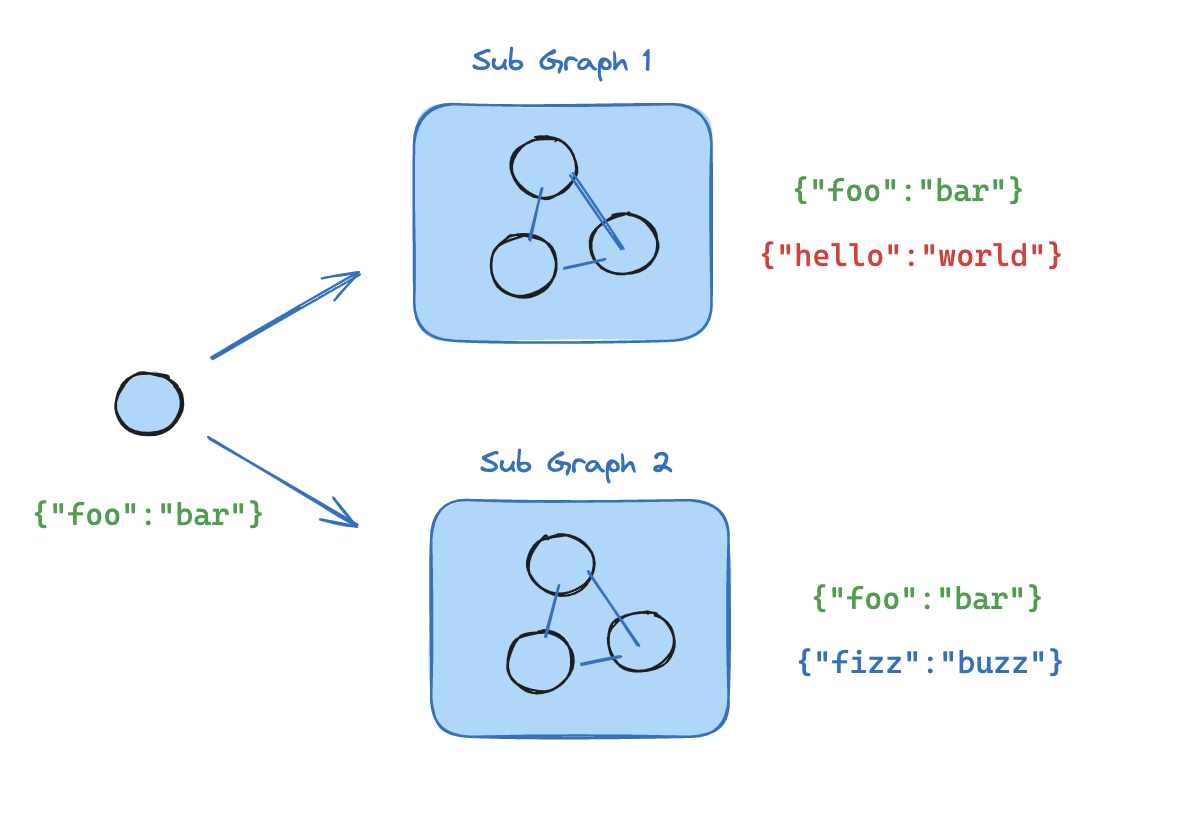

## Setup

First, let's install the required packages

```bash
npm install @langchain/langgraph @langchain/core
```

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Add a node with the compiled subgraph

A common case is for the parent graph and subgraph to communicate over a shared state key (channel). For example, in [multi-agent](https://langchain-ai.github.io/langgraphjs/concepts/multi_agent) systems, the agents often communicate over a shared [messages](https://langchain-ai.github.io/langgraphjs/concepts/low_level/#why-use-messages) key.

If your subgraph shares state keys with the parent graph, you can follow these steps to add it to your graph:

1. Define the subgraph workflow (`subgraphBuilder` in the example below) and compile it
2. Pass compiled subgraph to the `.addNode` method when defining the parent graph workflow

Let's take a look at an example. 

In [1]:
import { StateGraph, Annotation } from "@langchain/langgraph";

const SubgraphStateAnnotation = Annotation.Root({
  foo: Annotation<string>, // note that this key is shared with the parent graph state
  bar: Annotation<string>,
});

const subgraphNode1 = async (state: typeof SubgraphStateAnnotation.State) => {
  return { bar: "bar" };
};

const subgraphNode2 = async (state: typeof SubgraphStateAnnotation.State) => {
  // note that this node is using a state key ('bar') that is only available in the subgraph
  // and is sending update on the shared state key ('foo')
  return { foo: state.foo + state.bar };
};

const subgraphBuilder = new StateGraph(SubgraphStateAnnotation)
  .addNode("subgraphNode1", subgraphNode1)
  .addNode("subgraphNode2", subgraphNode2)
  .addEdge("__start__", "subgraphNode1")
  .addEdge("subgraphNode1", "subgraphNode2")

const subgraph = subgraphBuilder.compile();

// Define parent graph
const ParentStateAnnotation = Annotation.Root({
  foo: Annotation<string>,
});

const node1 = async (state: typeof ParentStateAnnotation.State) => {
  return {
    foo: "hi! " + state.foo,
  };
}

const builder = new StateGraph(ParentStateAnnotation)
  .addNode("node1", node1)
  // note that we're adding the compiled subgraph as a node to the parent graph
  .addNode("node2", subgraph)
  .addEdge("__start__", "node1")
  .addEdge("node1", "node2")

const graph = builder.compile();

In [2]:
const stream = await graph.stream({ foo: "foo" });

for await (const chunk of stream) {
  console.log(chunk);
}

{ node1: { foo: 'hi! foo' } }
{ node2: { foo: 'hi! foobar' } }


You can see that the final output from the parent graph includes the results of subgraph invocation (the string `"bar"`). 

If you would like to see streaming output from the subgraph, you can specify `subgraphs: True` when streaming. See more on streaming from subgraphs in this [how-to guide](https://langchain-ai.github.io/langgraphjs/how-tos/streaming-subgraphs/#stream-subgraph).

In [3]:
const streamWithSubgraphs = await graph.stream({ foo: "foo" }, { subgraphs: true });

for await (const chunk of streamWithSubgraphs) {
  console.log(chunk);
}

[ [], { node1: { foo: 'hi! foo' } } ]
[
  [ 'node2:22f27b01-fa9f-5f46-9b5b-166a80d96791' ],
  { subgraphNode1: { bar: 'bar' } }
]
[
  [ 'node2:22f27b01-fa9f-5f46-9b5b-166a80d96791' ],
  { subgraphNode2: { foo: 'hi! foobar' } }
]
[ [], { node2: { foo: 'hi! foobar' } } ]


You'll notice that the chunk output format has changed to include some additional information about the subgraph it came from.

## Add a node function that invokes the subgraph

For more complex systems you might want to define subgraphs that have a completely different schema from the parent graph (no shared keys). For example, in a multi-agent RAG system, a search agent might only need to keep track of queries and retrieved documents.

If that's the case for your application, you need to define a node **function that invokes the subgraph**. This function needs to transform the input (parent) state to the subgraph state before invoking the subgraph, and transform the results back to the parent state before returning the state update from the node.

Below we show how to modify our original example to call a subgraph from inside the node.

<div class="admonition warning">
    <p class="admonition-title">Note</p>
    <p>
      You <b>cannot</b> invoke more than one subgraph inside the same node if you have checkpointing enabled for the subgraphs. See <a href="../subgraph-persistence#define-the-graph-with-persistence">this page</a> for more information.
    </p>
</div>

In [5]:
import { StateGraph, Annotation } from "@langchain/langgraph";

const SubgraphAnnotation = Annotation.Root({
  bar: Annotation<string>, // note that this key is shared with the parent graph state
  baz: Annotation<string>,
});

const subgraphNodeOne = async (state: typeof SubgraphAnnotation.State) => {
  return { baz: "baz" };
};

const subgraphNodeTwo = async (state: typeof SubgraphAnnotation.State) => {
  return { bar: state.bar + state.baz }
};

const subgraphCalledInFunction = new StateGraph(SubgraphAnnotation)
  .addNode("subgraphNode1", subgraphNodeOne)
  .addNode("subgraphNode2", subgraphNodeTwo)
  .addEdge("__start__", "subgraphNode1")
  .addEdge("subgraphNode1", "subgraphNode2")
  .compile();

// Define parent graph
const ParentAnnotation = Annotation.Root({
  foo: Annotation<string>,
});

const nodeOne = async (state: typeof ParentAnnotation.State) => {
  return {
    foo: "hi! " + state.foo,
  };
}

const nodeTwo = async (state: typeof ParentAnnotation.State) => {
  const response = await subgraphCalledInFunction.invoke({
    bar: state.foo,
  });
  return { foo: response.bar }
}

const graphWithFunction = new StateGraph(ParentStateAnnotation)
  .addNode("node1", nodeOne)
  // note that we're adding the compiled subgraph as a node to the parent graph
  .addNode("node2", nodeTwo)
  .addEdge("__start__", "node1")
  .addEdge("node1", "node2")
  .compile();

In [6]:
const graphWithFunctionStream = await graphWithFunction.stream({ foo: "foo" }, { subgraphs: true });
for await (const chunk of graphWithFunctionStream) {
  console.log(chunk);
}

[ [], { node1: { foo: 'hi! foo' } } ]
[
  [ 'node2:1d2bb11a-3ed1-5c58-9b6f-c7af36a1eeb7' ],
  { subgraphNode1: { baz: 'baz' } }
]
[
  [ 'node2:1d2bb11a-3ed1-5c58-9b6f-c7af36a1eeb7' ],
  { subgraphNode2: { bar: 'hi! foobaz' } }
]
[ [], { node2: { foo: 'hi! foobaz' } } ]
